# Загрузка данных

In [687]:
graphics_color = '#b683ff'

In [688]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import numpy as np
import matplotlib.cbook as cbook

In [689]:
df = pd.read_csv('T_games_dataset.csv')
df.head()

,id,client_id,order_day,category_id,category_name,good_id,good_name,good_price,good_cnt,gender_cd,age,education_level,city_nm,monthly_income_amt,steam_popularity_score
0,1500571355,5-25R6ZT3L9,2023-05-22,29688,Скидки,890257,The Night of the Rabbit,299.00,1.0,M,28,UGR,Москва,73552,0.0
1,1500571245,5-2P4Z5VSMF,2023-05-22,28574,Ролевые (RPG),1436296,Ni no Kuni Wrath of the White Witch Remastered,269.85,1.0,M,26,GRD,Москва,281417,0.0
2,1500573164,5-YGO64ONA,2023-05-24,30659,Казуальные игры,1179848,KeyWe - The 100th Annual Grand Ol' Telepost To...,77.00,1.0,M,30,GRD,Москва,86000,0.0
3,1500364601,5-1VA0D94LX,2022-10-23,29688,Скидки,1204914,GTFO,1675.01,1.0,M,24,GRD,Самара,56000,283.0
4,1500288143,5-1QCUV9SY7,2022-07-03,28577,Экшн,1314503,Neon White,550.00,1.0,M,38,GRD,Санкт-Петербург,32000,1676.0


Размеры перед предобработкой:

In [690]:
n_purchases, n_users = df.shape[0], df['client_id'].nunique()
print('Number of purchases: {}'.format(n_purchases))
print('Number of users: {}'.format(n_users))

Number of purchases: 88699
Number of users: 41298


In [691]:
df['good_type'] = df['good_name'].apply(
    lambda x: 'DLC' if 'dlc' in x.lower() else 'Game')
df['is_DLC'] = df['good_type'] == 'DLC'

bundle_tags = ['edition', 'pack', 'collection', 'bundle', 'antology']

df['is_bundle'] = df['good_name'].apply(lambda x: (
    any(tag in x.lower() for tag in bundle_tags)) and ('dlc' not in x.lower()))

bundle_purchases = df[df['is_bundle']].copy()
bundle_purchases['is_DLC'] = True
bundle_purchases['good_name'] = bundle_purchases['good_name'].apply(
    lambda x: x + ' (dlc from bundle)')
df = pd.concat([df, bundle_purchases], axis=0)

donut = ['pass', 'coins', 'запасные детали', 'кейс', 'ключ']
df.loc[df['good_name'].apply(lambda x : any([tag in x.lower() for tag in donut])), 'is_DLC'] = False

edu_lvl_grade = {'SCH': 1, 'UGR': 2, 'GRD': 3, 'PGR': 4, 'ACD': 5}
edu_lvl_by_grade = {v: k for k, v in edu_lvl_grade.items()}

df['edu_lvl_grade'] = df['education_level'].map(edu_lvl_grade)

min_age_by_id = df.groupby('client_id')['age'].min()

max_age_by_id = df.groupby('client_id')['age'].max()

highest_edu_lvl_by_id = df.groupby('client_id')['education_level'].apply(
    lambda x: edu_lvl_by_grade[x.map(edu_lvl_grade).max()])

edu_lvls_by_id = df.groupby('client_id')['education_level'].apply(
    lambda x: x.drop_duplicates().tolist())

age_by_edu_lvl_treshold = {
    'SCH': 0, 'UGR': 16, 'GRD': 22, 'PGR': 26, 'ACD': 31}

client_ids = df['client_id'].drop_duplicates()

----

Странно меняющийся возраст

In [692]:
n_strange_age = client_ids[client_ids.map(lambda x: max_age_by_id[x] - min_age_by_id[x] > 3)].shape[0]
print(f'Strange age users: {n_strange_age} ({n_strange_age / n_users * 100:.2f}%)')
client_ids = client_ids[client_ids.map(lambda x: max_age_by_id[x] - min_age_by_id[x] <= 3)]


Strange age users: 10 (0.02%)


In [693]:
client_ids.map(lambda x: max_age_by_id[x] - min_age_by_id[x]).value_counts()

0    41288
Name: client_id, dtype: int64

----

Дубликаты покупок

In [694]:

n_duplicated_purchases = df[df.duplicated(subset=['client_id', 'good_name'])].shape[0]
print(f'Duplicated purchases: {n_duplicated_purchases} ({n_duplicated_purchases / n_purchases * 100:.2f}%)')
df.drop_duplicates(subset=['client_id', 'good_name'], inplace=True)

Duplicated purchases: 6445 (7.27%)


----

Люди младше 14 лет

In [695]:
n_less_14 = client_ids[client_ids.map(lambda x: min_age_by_id[x] < 14)].shape[0]
print(f'Users less than 14: {n_less_14} ({n_less_14 / n_users * 100:.2f}%)')
client_ids = client_ids[client_ids.map(lambda x: min_age_by_id[x] >= 14)]

Users less than 14: 1272 (3.08%)


----

Выбросы по возрасту

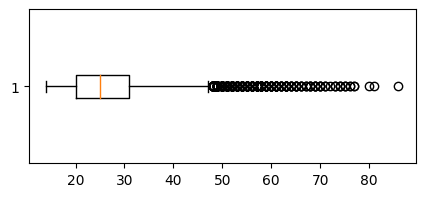

In [696]:
fig = plt.figure(figsize=(5, 2))
plt.boxplot(client_ids.map(min_age_by_id), vert=False);

In [697]:
stats = cbook.boxplot_stats(client_ids.map(min_age_by_id))
lower_threshold = stats[0]['whislo']
upper_threshold = stats[0]['whishi']

print(f"Lower threshold: {lower_threshold}")
print(f"Upper threshold: {upper_threshold}")
deleted = client_ids.shape[0] - client_ids[client_ids.map(min_age_by_id).between(lower_threshold, upper_threshold)].shape[0]
print(f'Deleted {deleted} users ({deleted / n_users * 100:.2f}%)')
client_ids = client_ids[client_ids.map(min_age_by_id).between(lower_threshold, upper_threshold)]

Lower threshold: 14
Upper threshold: 47
Deleted 578 users (1.40%)


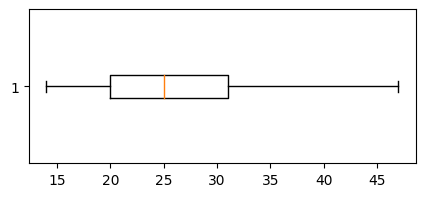

In [698]:
fig = plt.figure(figsize=(5, 2))
plt.boxplot(client_ids.map(min_age_by_id), vert=False);

----

Корректировка уровня образования

In [699]:
def correct_edu_lvl(cliend_id):
    age = min_age_by_id[cliend_id]
    max_lvl = max([edu_lvl_grade[lvl] for lvl in edu_lvls_by_id[cliend_id]])
    while age < age_by_edu_lvl_treshold[edu_lvl_by_grade[max_lvl]]:
        max_lvl -= 1
    return edu_lvl_by_grade[max_lvl]

In [700]:
df['education_level'] = df['client_id'].map(correct_edu_lvl)

----

Обработка дохода

In [701]:
min_income_by_id = df.groupby('client_id')['monthly_income_amt'].min()
mean_income_by_id = df.groupby('client_id')['monthly_income_amt'].mean()
n_negative_minimal_income = client_ids[client_ids.map(min_income_by_id) < 0].shape[0]
print(f'Users with negative minimal income: {n_negative_minimal_income} ({n_negative_minimal_income / n_users * 100:.2f}%)')
client_ids = client_ids[client_ids.map(min_income_by_id) >= 0]

Users with negative minimal income: 7151 (17.32%)


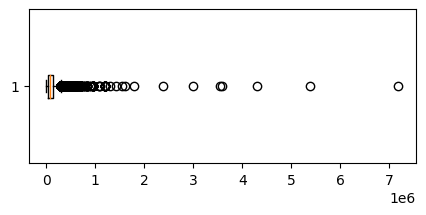

In [702]:
plt.figure(figsize=(5, 2))
plt.boxplot(client_ids.map(mean_income_by_id), vert=False);

In [703]:
stats = cbook.boxplot_stats(client_ids.map(mean_income_by_id))
lower_threshold = stats[0]['whislo']
upper_threshold = stats[0]['whishi']

print(f"Lower threshold: {lower_threshold}")
print(f"Upper threshold: {upper_threshold}")
n_deleted = client_ids.shape[0] - client_ids[client_ids.map(mean_income_by_id).between(lower_threshold, upper_threshold)].shape[0]
print(f'Deleted {n_deleted} users ({n_deleted / n_users * 100:.2f}%)')
client_ids = client_ids[client_ids.map(mean_income_by_id).between(lower_threshold, upper_threshold)]

Lower threshold: 32.0
Upper threshold: 298916.0
Deleted 1585 users (3.84%)


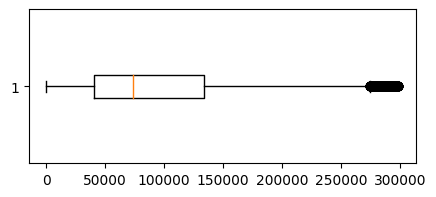

In [715]:
plt.figure(figsize=(5, 2))
plt.boxplot(client_ids.map(mean_income_by_id), vert=False);

In [705]:
df = df[df['client_id'].isin(client_ids)]

----

Осталось после чистки

In [706]:
print(f'Rows: {len(df)}, {len(df) / n_purchases * 100:.2f}% from original')
print(
    f'Clients: {len(client_ids)}, {len(client_ids) / n_users * 100:.2f}% from original')

Rows: 64479, 72.69% from original
Clients: 30702, 74.34% from original


----

Некоторая статистика по оставшимся пользователям

In [683]:
dlc_to_all_ratio_by_id = df.groupby('client_id')['is_DLC'].mean()

mean_good_price_by_id = df.groupby(['client_id', 'id'])['good_price'].sum().groupby('client_id').mean()

# Анализ

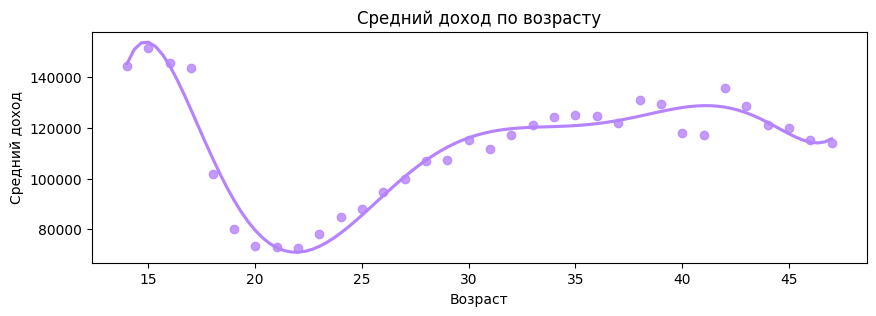

In [569]:
plt.figure(figsize=(10, 3))
df1 = pd.DataFrame({'age': client_ids.map(min_age_by_id),
                   'mean income': client_ids.map(mean_income_by_id)})
df1 = df1[df1['age'].between(14, 50)]
df2 = df1.groupby('age')['mean income'].mean().reset_index()
sns.regplot(x='age', y='mean income', data=df2, order=7,
            ci=None, color=graphics_color)
plt.xlabel('Возраст')
plt.ylabel('Средний доход')
plt.title('Средний доход по возрасту')
plt.show()

In [570]:
def find_w0_w1(x, y):
    w1 = ((x - x.mean()) * (y - y.mean())).sum() / ((x - x.mean()) ** 2).sum()
    w0 = y.mean() - w1 * x.mean()
    return w0, w1

In [571]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.7658
Date:                Tue, 19 Dec 2023   Prob (F-statistic):              0.393
Time:                        15:31:37   Log-Likelihood:                 57.722
No. Observations:                  20   AIC:                            -111.4
Df Residuals:                      18   BIC:                            -109.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2445      0.020     11.992      0.0

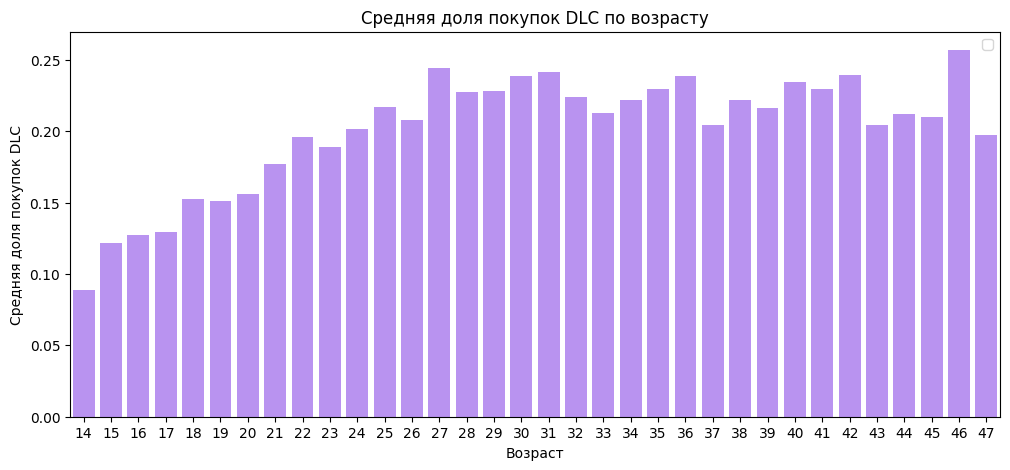

In [572]:
# age_groups = [(14, 27), (27, 47)]
age_groups = [(27, 47)]

fig = plt.figure(figsize=(12, 5))

df1 = pd.DataFrame({'age': client_ids.map(min_age_by_id), 'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})

df1 = df1.groupby('age')['dlc_to_all_ratio'].mean().reset_index()

for min_age, max_age in age_groups:
    x = np.arange(min_age, max_age)
    y = df1[df1['age'].isin(x)]['dlc_to_all_ratio'].values
    
    model = sm.OLS(y, sm.add_constant(x)).fit()
    print(model.summary())
    
    # plt.plot(x - 14, w0 + w1 * np.array(x), label=f'От {min_age} до {max_age} лет', color = 'red')
    # annot = f'k = {w1:.3f}, r2 = {r2_score(y, w0 + w1 * x):.3f}, mae = {mean_absolute_error(y, w0 + w1 * x):.8f}'
    # plt.annotate(annot, (x.mean() - 14, 1.05 * (w0 + w1 * x.mean())), fontsize=12)
    

plt.legend()

plt.title("Средняя доля покупок DLC по возрасту")

df1 = pd.DataFrame({'age': client_ids.map(min_age_by_id),
                   'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})
df1 = df1[df1['age'].between(14, 50)]
df2 = df1.groupby('age')['dlc_to_all_ratio'].mean().reset_index()
sns.barplot(x='age', y='dlc_to_all_ratio', data=df2, color=graphics_color)
plt.xlabel('Возраст')
plt.ylabel('Средняя доля покупок DLC');

                            OLS Regression Results                            
Dep. Variable:       dlc_to_all_ratio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                  0.002465
Date:                Tue, 19 Dec 2023   Prob (F-statistic):              0.961
Time:                        15:36:30   Log-Likelihood:                 82.317
No. Observations:                  45   AIC:                            -160.6
Df Residuals:                      43   BIC:                            -157.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1915      0.012     16.437      0.0

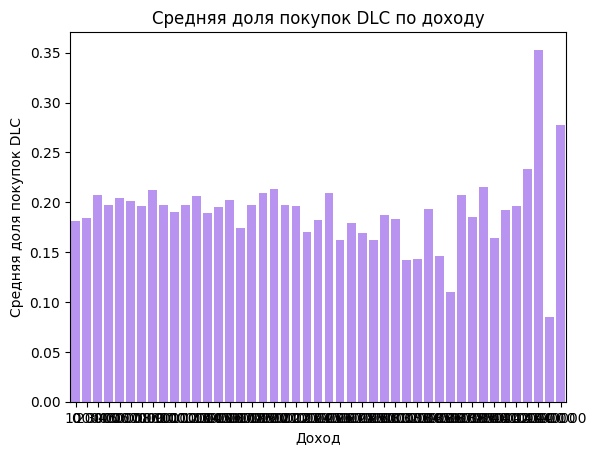

In [582]:
plt.title("Средняя доля покупок DLC по доходу")

df1 = pd.DataFrame({'income': client_ids.map(mean_income_by_id).apply(lambda x: int(x / 10000) * 10000),
                   'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})

# df1 = df1[df1['age'].between(14, 50)]
df2 = df1.groupby('income')['dlc_to_all_ratio'].mean().reset_index()
bars = sns.barplot(x='income', y='dlc_to_all_ratio', data=df2, color=graphics_color)
plt.xlabel('Доход')
plt.ylabel('Средняя доля покупок DLC')

x = df2['income']
y = df2['dlc_to_all_ratio']

model = sm.OLS(y, sm.add_constant(x)).fit()

print(model.summary())

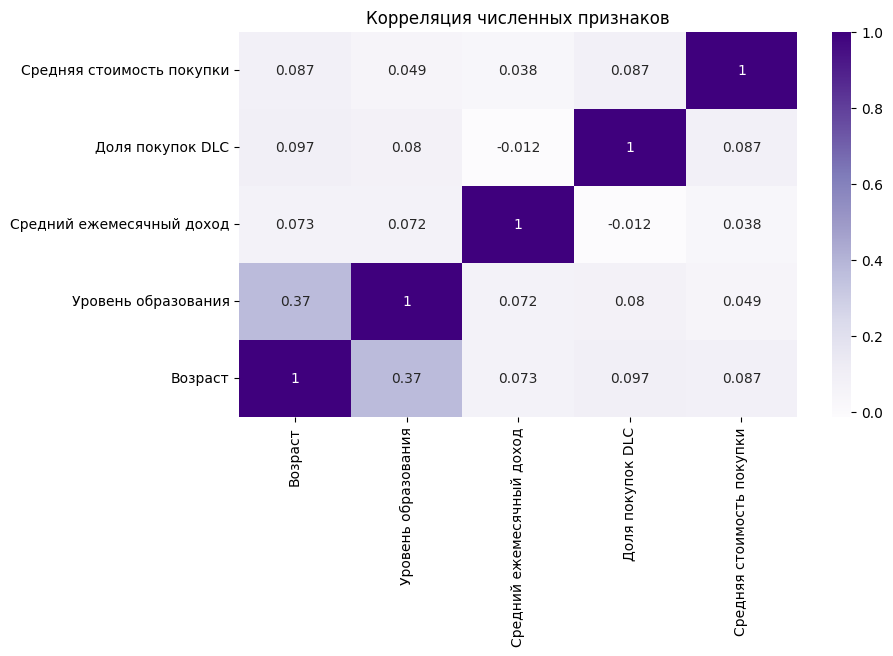

In [574]:
fig = plt.figure(figsize=(9, 5))
numeric_features = pd.DataFrame({'Возраст': client_ids.map(min_age_by_id), 'Уровень образования': client_ids.map(correct_edu_lvl).apply(lambda x: edu_lvl_grade[x]), 'Средний ежемесячный доход': client_ids.map(mean_income_by_id), 'Доля покупок DLC': client_ids.map(dlc_to_all_ratio_by_id), 'Средняя стоимость покупки': client_ids.map(mean_good_price_by_id)})
correlation_matrix = numeric_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Purples)
plt.gca().invert_yaxis()
plt.title('Корреляция численных признаков')
plt.show()

In [575]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [576]:
ids1 = client_ids[client_ids.map(min_age_by_id).between(14, 30)]
df1 = pd.DataFrame({'edu_lvl': ids1.map(correct_edu_lvl), 'dlc_ratio' : ids1.map(dlc_to_all_ratio_by_id)})
X = df1['edu_lvl']
y = df1['dlc_ratio']
X = pd.get_dummies(X)

In [577]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [578]:
r2_score(y, model.predict(X))

0.008560303001281078